# Importing libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
import cv2
import torch
from torchvision import transforms
from mtcnn import MTCNN
import os
import torch.nn.functional as F
import pandas as pd

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Read the preprocessed dataset

In [3]:
# Data path
train_path = './data/train_data/'
val_path = './data/val_data/'
test_path = './data/test_data/'

In [4]:
# Load train
X_train = np.load(train_path + 'Xtrain.npy')
y_train = np.load(train_path + 'ytrain.npy')

In [7]:
# Load validation
X_val = np.load(val_path + 'Xval.npy')
y_val = np.load(val_path + 'yval.npy')

In [8]:
# Load test
X_test = np.load(test_path + 'Xtest.npy')
y_test = np.load(test_path + 'ytest.npy')

In [9]:
# Convert targets to float32
y_train = y_train.astype(np.float32)
y_val = y_val.astype(np.float32)
y_test = y_test.astype(np.float32)

In [10]:
# Convert inputs to float32
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)
X_test = X_test.astype(np.float32)

In [11]:
from dataset import TorchDatasetCreator
from torch.utils.data import DataLoader

In [12]:
# Batch size for the loaders
batch_size = 32

In [13]:
# DataLoader provides the (Image, Age_label, Gender_label)
train_dataset = TorchDatasetCreator(dataset = (X_train, y_train[:, 0].reshape(-1), y_train[:, 1].reshape(-1)))
val_dataset = TorchDatasetCreator(dataset = (X_val, y_val[:, 0].reshape(-1), y_val[:, 1].reshape(-1)))
test_dataset = TorchDatasetCreator(dataset = (X_test, y_test[:, 0].reshape(-1), y_test[:, 1].reshape(-1)))

In [14]:
# Don't shuffle the data as it is already shuffled
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle = False, pin_memory = True)

In [15]:
from train import trainer, evaluate

In [16]:
from model import BaseModel

In [15]:
model_gender = BaseModel().to(device)

C:\Users\hrayr\anaconda3\envs\acoustic\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\hrayr\anaconda3\envs\acoustic\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [16]:
# Parameters for the training
learning_rate_gender = 0.000001
optimizer_gender = torch.optim.Adam(model_gender.parameters(), lr=learning_rate_gender)
loss_fn_gender = torch.nn.BCELoss()

Starting the training of task - Gender prediction.

EPOCH 01/30 | batch train loss = 0.0355331 | ====================> 100.00%

Validation loss was better than before, saving weights in: Gender_Model_BaseModel.pt

Average train loss = 0.018978

Validation loss = 0.015660

Train accuracy = 0.7258

Validation accuracy = 0.9112
-----------------------------------

EPOCH 02/30 | batch train loss = 0.0281380 | ====================> 100.00%

Validation loss was better than before, saving weights in: Gender_Model_BaseModel.pt

Average train loss = 0.013118

Validation loss = 0.010169

Train accuracy = 0.9219

Validation accuracy = 0.9289
-----------------------------------

EPOCH 03/30 | batch train loss = 0.0240332 | ====================> 100.00%

Validation loss was better than before, saving weights in: Gender_Model_BaseModel.pt

Average train loss = 0.008778

Validation loss = 0.007015

Train accuracy = 0.9381

Validation accuracy = 0.9433
-----------------------------------

EPOCH 04/30 

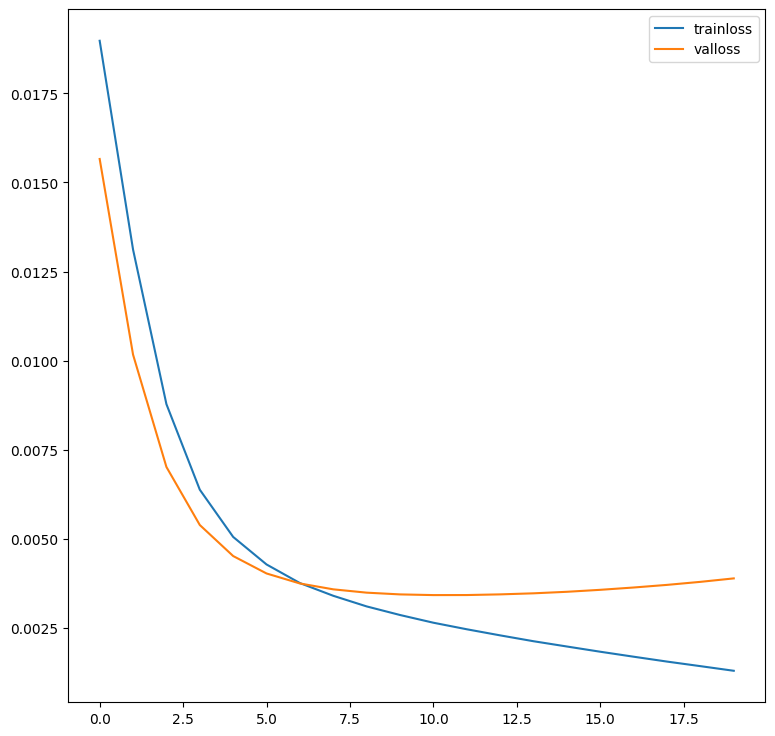

In [17]:
trainer(model_gender, train_loader, val_loader, optimizer_gender, loss_fn_gender, task='Gender', epochs=30)

In [17]:
# Load the trained weights
model_gender = BaseModel().to(device)
model_gender.load_state_dict(torch.load('./weights/Gender_Model_BaseModel_Best.pt'))

C:\Users\hrayr\anaconda3\envs\acoustic\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
C:\Users\hrayr\anaconda3\envs\acoustic\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>

In [18]:
from helper import calc_preds, find_worst_preds

In [19]:
# Predictions for each set
gender_predictions_train = calc_preds(model_gender, X_train, y_train, classification=True)
gender_predictions_test = calc_preds(model_gender, X_test, y_test, classification=True)
gender_predictions_val = calc_preds(model_gender, X_val, y_val, classification=True)

In [20]:
def loader_accuracy(net, loader):
    """
    Function calculates the accuracy for a certain data_loader
    
    """
    running_corrects = 0
    for batch_idx, batch in enumerate(loader):
        
        inputs, _, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)
        prediction = net(inputs).squeeze(-1) 
          
        prediction = torch.sigmoid(prediction)
        
        running_corrects = running_corrects + (prediction.round()==labels).sum()
        
    return running_corrects / len(loader.dataset)

In [21]:
# Calculate accuracies
train_acc = loader_accuracy(model_gender, train_loader)
test_acc = loader_accuracy(model_gender, test_loader)
val_acc = loader_accuracy(model_gender, val_loader)

In [22]:
print('Train accuracy =',np.round(train_acc.item(), 4))
print('Test accuracy =',np.round(test_acc.item(), 4))
print('Validation accuracy =',np.round(val_acc.item(), 4))

Train accuracy = 0.9774
Test accuracy = 0.961
Validation accuracy = 0.9605


In [23]:
# Sort the indices by worst predictions (prediction error is the highest)
highest_error_idx_test = find_worst_preds(gender_predictions_test)

In [24]:
n_worst = 20

In [25]:
# Gender mapping
gender_mapping = {1: 'Female', 0: 'Male'}

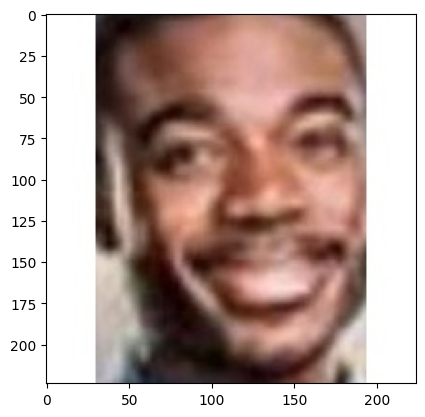



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9985530376434326
--------------------------------------------------


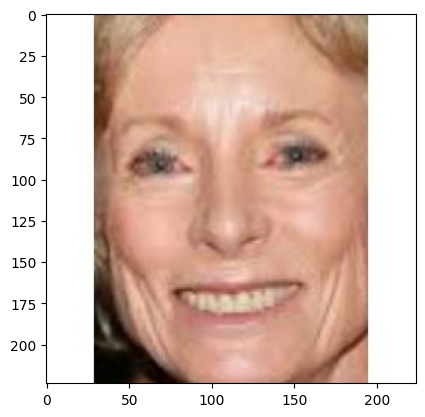



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9980271458625793
--------------------------------------------------


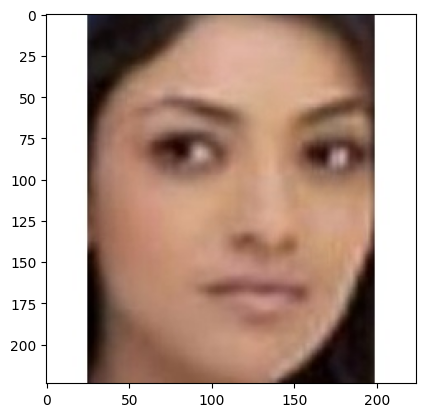



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9970989227294922
--------------------------------------------------


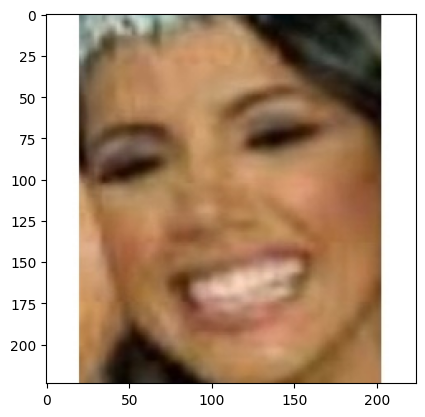



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9966989159584045
--------------------------------------------------


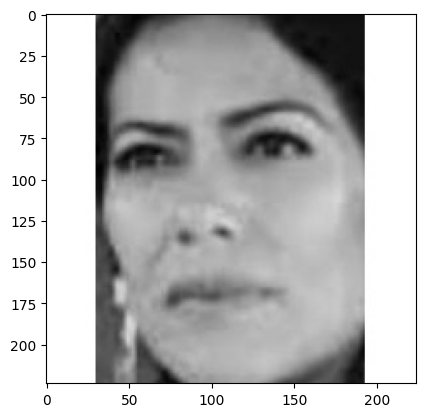



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9957337975502014
--------------------------------------------------


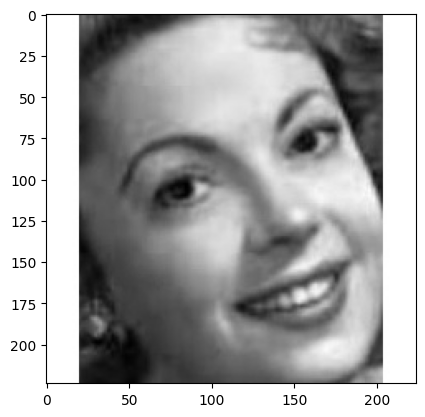



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9950774312019348
--------------------------------------------------


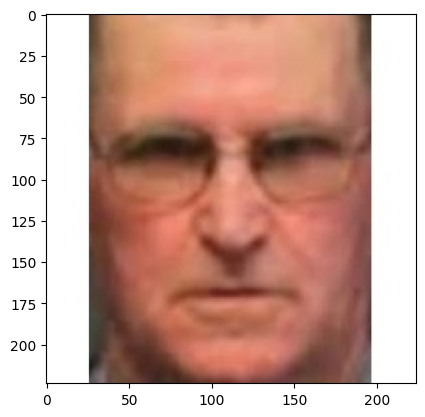



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9943844079971313
--------------------------------------------------


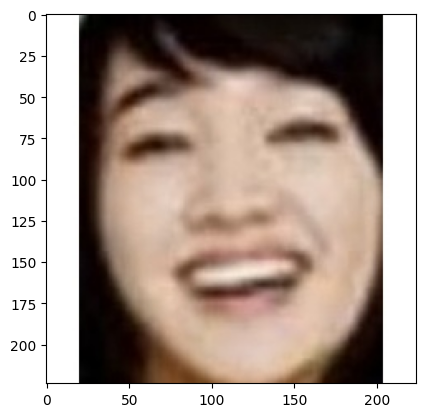



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9922254085540771
--------------------------------------------------


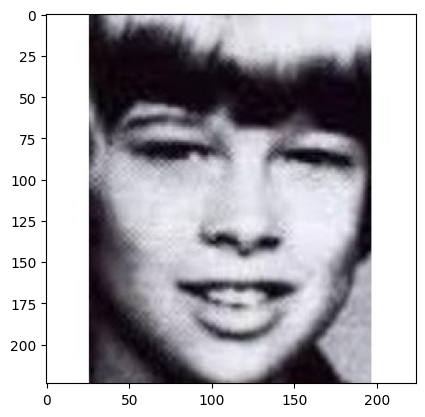



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9922173023223877
--------------------------------------------------


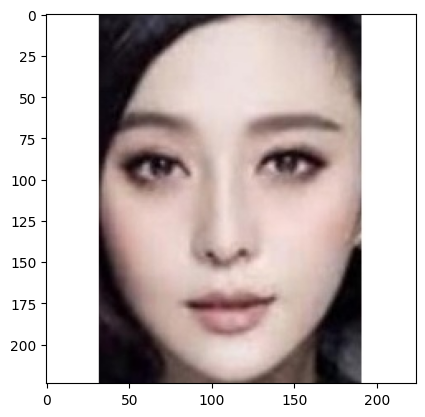



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.991824209690094
--------------------------------------------------


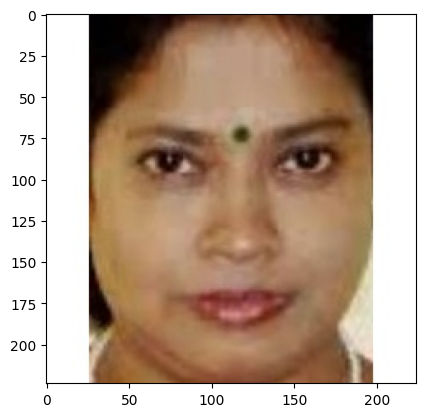



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9910526871681213
--------------------------------------------------


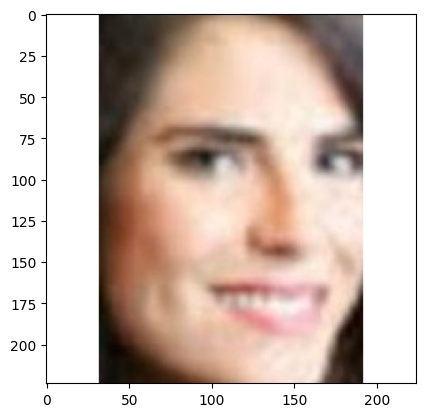



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9877194166183472
--------------------------------------------------


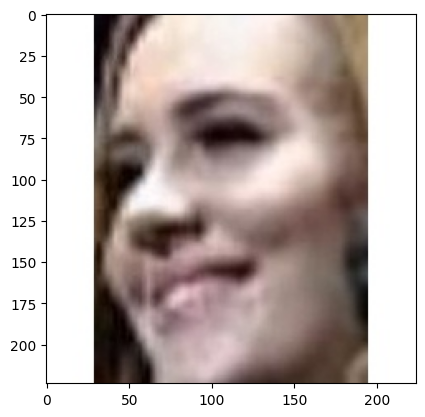



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9874209761619568
--------------------------------------------------


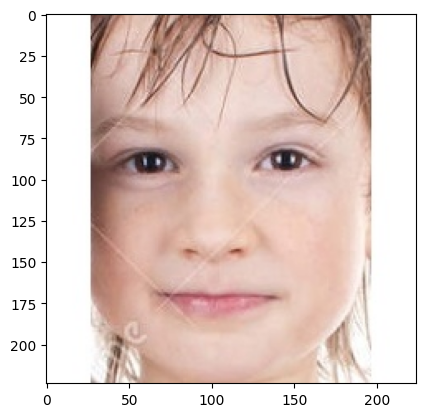



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9873692393302917
--------------------------------------------------


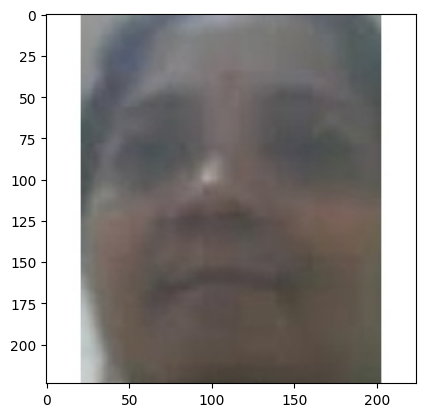



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9850516319274902
--------------------------------------------------


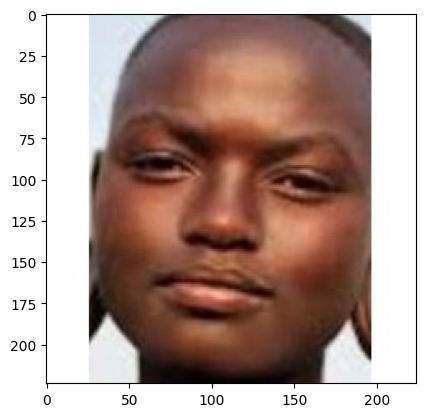



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9850143194198608
--------------------------------------------------


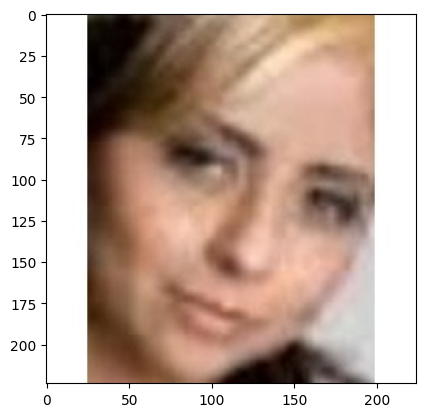



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9827367067337036
--------------------------------------------------


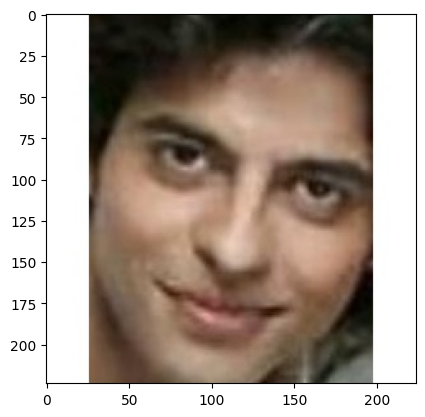



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9824389219284058
--------------------------------------------------


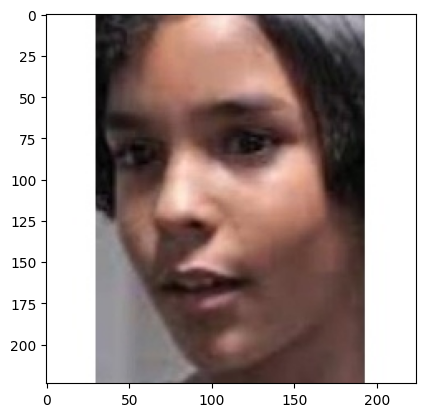



--------------------------------------------------
Correct label = Male
Predicted label = Female
Error = 0.9807151556015015
--------------------------------------------------


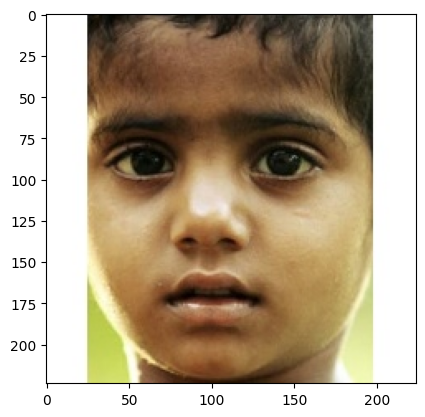



--------------------------------------------------
Correct label = Female
Predicted label = Male
Error = 0.9797906279563904
--------------------------------------------------


In [26]:
# Plot wrong predictions for test dataset
for ex in highest_error_idx_test[:n_worst]:
    plt.imshow(X_test[ex].astype(np.uint8))
    plt.show()
    correct_label = gender_mapping[int(gender_predictions_test[ex][0])]
    predicted_label = gender_mapping[np.round(gender_predictions_test[ex][1])]
    error = gender_predictions_test[ex][2]
    print('\n')
    print('-'*50)
    print('Correct label =', correct_label)
    print('Predicted label =', predicted_label)
    print('Error =', error)
    print('-'*50)